<h1 align=center><font size = 6>Capstone Project - Venue Comparison Analysis between Manhattan and Toronto</font></h1>

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)

## Introduction <a name="introduction"></a>

New York City and Toronto are two prosperous cities and they are both financial capitals of their respective cities. From a geographic point, United States adjoins Canada and these two cities are close with even a driving distance. 8.6 million people live in New York City and 2.9 million people live in Toronto.  To be more specific, if we just look at Manhattan, which is the center of New York City, there is still 1.7 million people. So, what attracts our interests is that how do these two cities share the similarity and how could they be different from each other. By asking this question, we will have a general overview of these two cities and people who want to choose one of them to live in could be benefited.

To understand the characters of each city we should explore the venues and analysis its make-up and categories. Data would contribute to the city exploring should include the detailed neighborhood and venue information. To plot the map of both cities, the data should also contain the coordinates (latitude and longitude) of each neighborhood.

This exploring will benefit those people who want to have a better understanding of both cities especially for those people who want to choose one of them to live in. Since the exploring will also focus the detail venues in the city, it could also provide the traveler and native resident a general map of the special properties of the city.

## Data <a name="data"></a>

Based our problem, information we might need are:
* number of venues in the neighborhood and their categories
* geographic information of all the city/neighborhood/venue

Following data sources will be needed to extract/generate the required information:
* New York city data from the server: https://cocl.us/new_york_dataset
* Toronto data scraped from the link https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M and merged with coordinates table in the sever http://cocl.us/Geospatial_data
* number of venues and their type and location in every neighborhood will be obtained using **Foursquare API**

#### Import libraries

In [1]:
from bs4 import BeautifulSoup

import numpy as np 

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.3


#### Get the data and Create the City Map

Let's first create the dataframe for New York City and create the city map with neighborhood markers

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
neighborhoods_data = newyork_data['features']

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
print(neighborhoods.count())
neighborhoods.head()

Borough         306
Neighborhood    306
Latitude        306
Longitude       306
dtype: int64


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Now let's create the map using folium library and add markers

In [5]:
address1 = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location1 = geolocator.geocode(address1)
latitude1 = location1.latitude
longitude1 = location1.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude1, longitude1))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [6]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude1, longitude1], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Since there are too many neighborhoods in the whole New York City area, we just focus on the Manhattan area. What we do is to limit the Borough to Manhattan. We will create the new dataframe and map**

In [7]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)

address2 = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location2 = geolocator.geocode(address2)
latitude2 = location2.latitude
longitude2 = location2.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude2, longitude2))
manhattan_data.count()

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


Borough         40
Neighborhood    40
Latitude        40
Longitude       40
dtype: int64

In [8]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude2, longitude2], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

**follow the same idea, let's scrape the data and create the Tornto Map**

In [9]:
URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(URL)
soup =  BeautifulSoup(response.text, 'html.parser')

table = soup.find('table', {'class':'wikitable sortable'}).tbody

rows = table.find_all('tr')

columns = [v.text.replace('\n', '') for v in rows[0].find_all('th')]

df = pd.DataFrame(columns=columns)

for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    
    values = [tds[0].text, tds[1].text, tds[2].text.replace('\n', '')]
        
    df = df.append(pd.Series(values, index=columns), ignore_index=True)

df=df[df.Borough !='Not assigned']
df.reset_index()

df1=df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(lambda x: ', '.join(x.astype(str))).reset_index()

df1=df1.rename(index=str, columns={"Postcode": "Postal Code"})

df2 = pd.read_csv('http://cocl.us/Geospatial_data')

df3 = pd.merge(df1, df2, on='Postal Code', how='outer')

df3.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)

df3.count()
df3.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [10]:
address3 = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="Tor_explorer")
location3 = geolocator.geocode(address3)
latitude3 = location3.latitude
longitude3 = location3.longitude

In [11]:
# create map of Toronto using latitude and longitude values
map_Tor = folium.Map(location=[latitude3, longitude3], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df3['Latitude'], df3['Longitude'], df3['Borough'], df3['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Tor)  
    
map_Tor

## Methodology <a name="methodology"></a>

From the datasets above we get the corresponding borough, neighborhood and coordinates information. From Foursquare API we get the detailed venues information. The coordinates will help us plot the geographic map of both cities and see the distribution of the neighborhoods. The venues will help us have a general overview of the city facilities. The specific type of venue can also be put into a further discussion and exploration.

We will first explore what is the make-up of those venues and try to figure out the top 5 venues in each area. We will then use those venue data to explore some key venues like restaurant, museum and gym. After that we will focus on one most common venue and explore its categories and corresponding make-ups, like a kind of restaurant. Finally we will be even more specific and try to locate this venue category in the city maps and observe its distributions.  

#### Now let's use Foursquare API to get venue data for both cities

In [12]:
CLIENT_ID = 'VZOIUYQI4ZRL12N4NLCC2SX1VQRXEEGNDKPXKN11PKKJHIJD' # your Foursquare ID
CLIENT_SECRET = '220WOB0TJDBSYKBARZN53PRAFW3MOMDFH1PYXOPUVUJ3OL10' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VZOIUYQI4ZRL12N4NLCC2SX1VQRXEEGNDKPXKN11PKKJHIJD
CLIENT_SECRET:220WOB0TJDBSYKBARZN53PRAFW3MOMDFH1PYXOPUVUJ3OL10


In [13]:
LIMIT = 100 

radius = 500 

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Manhattan Venues

In [14]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )


Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [15]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3317, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


**We will then count these venues by categories**

**Analyze Manhattan Neighbourhood**

In [16]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Gym,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Re

**Let's do a sum up for the dataframe above**

In [17]:
sum_man = manhattan_onehot.sum(axis=0)
SUM_man = pd.to_numeric(sum_man, errors='coerce')
man_ven = pd.DataFrame(SUM_man)
man_ven.reset_index(inplace=True)
man_ven.rename(columns={'index':'venues', 0:'count'}, inplace=True)
man_ven.set_index('venues', inplace=True)
man_ven.dropna(inplace=True)

#### Total Venues in Manhattan

In [18]:
print('Total Venues in Manhattan')
man_ven.sum()

Total Venues in Manhattan


count    3317.0
dtype: float64

#### Top 5 Venues in Manhattan

In [19]:
man_ven.sort_values(by='count', ascending=False, inplace=True)

print('Top 5 venues in Manhattan:')
man_ven.head()

Top 5 venues in Manhattan:


,count
venues,
Italian Restaurant,126.0
Coffee Shop,123.0
American Restaurant,80.0
Café,78.0
Bakery,73.0


### Toronto Venues

#### Explore the Toronto Neighborhoods

In [20]:
Tor_venues = getNearbyVenues(names=df3['Neighborhood'],
                                   latitudes=df3['Latitude'],
                                   longitudes=df3['Longitude']
                                  )
Tor_venues.head()  

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge, Malvern",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
4,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum


#### Analyze Toronto Neighborhood

In [21]:
# one hot encoding
Tor_onehot = pd.get_dummies(Tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Tor_onehot['Neighborhood'] = Tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Tor_onehot.columns[-1]] + list(Tor_onehot.columns[:-1])
Tor_onehot = Tor_onehot[fixed_columns]

Tor_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

**The same, let's sum them up and do a summary**

In [22]:
sum_Tor = Tor_onehot.sum(axis=0)
SUM_Tor = pd.to_numeric(sum_Tor, errors='coerce')
tor_ven = pd.DataFrame(SUM_Tor)
tor_ven.reset_index(inplace=True)
tor_ven.rename(columns={'index':'venues', 0:'count'}, inplace=True)
tor_ven.set_index('venues', inplace=True)
tor_ven.dropna(inplace=True)

#### Total Venue Numbers in Toronto

In [23]:
print('Total Venue Numbers in Toronto')
tor_ven.sum()

Total Venue Numbers in Toronto


count    2244.0
dtype: float64

#### Top 5 Venues in Toronto

In [24]:
tor_ven.sort_values(by='count', ascending=False, inplace=True)

print('Top 5 Venues in Toronto')
tor_ven.head()

Top 5 Venues in Toronto


,count
venues,
Coffee Shop,186.0
Café,105.0
Restaurant,61.0
Pizza Place,57.0
Bakery,55.0


## Analysis <a name="analysis"></a>

### Exploare Specific Venues in Both Cities

#### Venues Make-up: Portion of Restaurant, Museum, Gym, Bar

**Manhattan**

In [25]:
man_R = [col for col in manhattan_onehot.columns if 'Restaurant' in col]
man_resta = man_ven.loc[man_R]

man_M = [col for col in manhattan_onehot.columns if 'Museum' in col]
man_muse = man_ven.loc[man_M]

man_G = [col for col in manhattan_onehot.columns if 'Gym' in col]
man_gym = man_ven.loc[man_G]

man_B = [col for col in manhattan_onehot.columns if 'Bar' in col]
man_bar = man_ven.loc[man_B]


x = sum(man_ven['count'])
x1 = sum(man_resta['count'])
x2 = sum(man_muse['count'])
x3 = sum(man_gym['count'])
x4 = sum(man_bar['count'])

d = {'Venue': ['Restaurant', 'Museum', 'Gym', 'Bar', 'Other Venues'], 'Count': [x1, x2, x3, x4, x-x1-x2-x3-x4]}
df_x = pd.DataFrame(data=d)
df_x.head()

,Venue,Count
0,Restaurant,926.0
1,Museum,16.0
2,Gym,127.0
3,Bar,229.0
4,Other Venues,2019.0


**Let's plot the pie chart to take a look at the portion of each venue**

In [26]:
df_x.set_index('Venue', inplace=True)

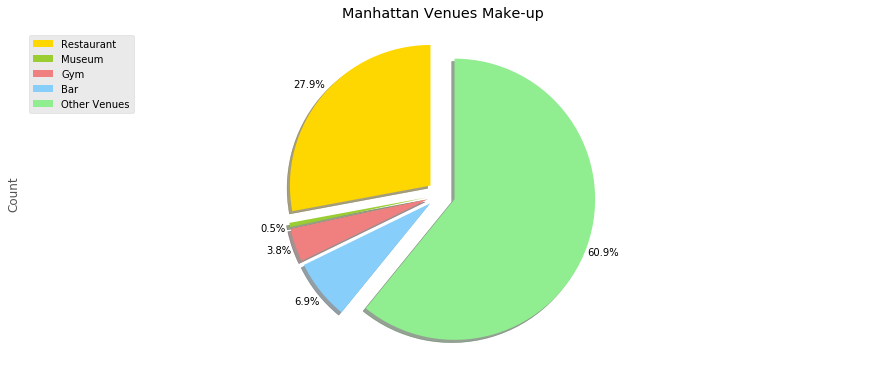

In [27]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen']
explode_list = [0.1, 0.1, 0.1, 0.1, 0.1] # ratio for each continent with which to offset each wedge.

df_x['Count'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('Manhattan Venues Make-up', y=1.02) 

plt.axis('equal') 

# add legend
plt.legend(labels=df_x.index, loc='upper left') 

plt.show()

#### Toronto

In [28]:
tor_R = [col for col in Tor_onehot.columns if 'Restaurant' in col]
tor_resta = tor_ven.loc[tor_R]

tor_M = [col for col in Tor_onehot.columns if 'Museum' in col]
tor_muse = tor_ven.loc[tor_M]

tor_G = [col for col in Tor_onehot.columns if 'Gym' in col]
tor_gym = tor_ven.loc[tor_G]

tor_B = [col for col in Tor_onehot.columns if 'Bar' in col]
tor_bar = tor_ven.loc[tor_B]


y = sum(tor_ven['count'])
y1 = sum(tor_resta['count'])
y2 = sum(tor_muse['count'])
y3 = sum(tor_gym['count'])
y4 = sum(tor_bar['count'])

f = {'Venue': ['Restaurant', 'Museum', 'Gym', 'Bar', 'Other Venues'], 'Count': [y1, y2, y3, y4, y-y1-y2-y3-y4]}
df_y = pd.DataFrame(data=f)
df_y.head()

,Venue,Count
0,Restaurant,523.0
1,Museum,11.0
2,Gym,48.0
3,Bar,111.0
4,Other Venues,1551.0


**Again, let's do the pie chart**

In [29]:
df_y.set_index('Venue', inplace=True)

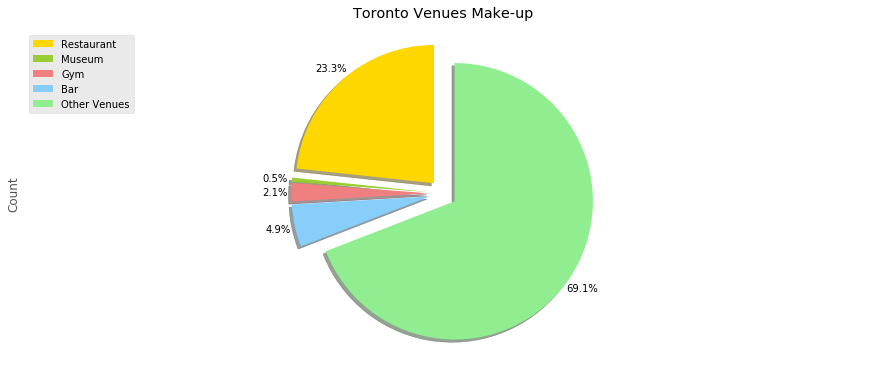

In [30]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen']
explode_list = [0.1, 0.1, 0.1, 0.1, 0.1] # ratio for each continent with which to offset each wedge.

df_y['Count'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 10.2% to match pctdistance
plt.title('Toronto Venues Make-up', y=1.02) 

plt.axis('equal') 

# add legend
plt.legend(labels=df_y.index, loc='upper left') 

plt.show()

### Now let's do some more specfic analysis for a specfic venue: Restaurant

#### Restaurant Explore

**Manhattan**

In [31]:
man_resta.sort_values(by='count', ascending=True, inplace=True)
print(man_resta.count())
man_resta.tail()

count    78
dtype: int64


,count
venues,
Sushi Restaurant,49.0
French Restaurant,53.0
Mexican Restaurant,55.0
American Restaurant,80.0
Italian Restaurant,126.0


Now let's create a pie chart

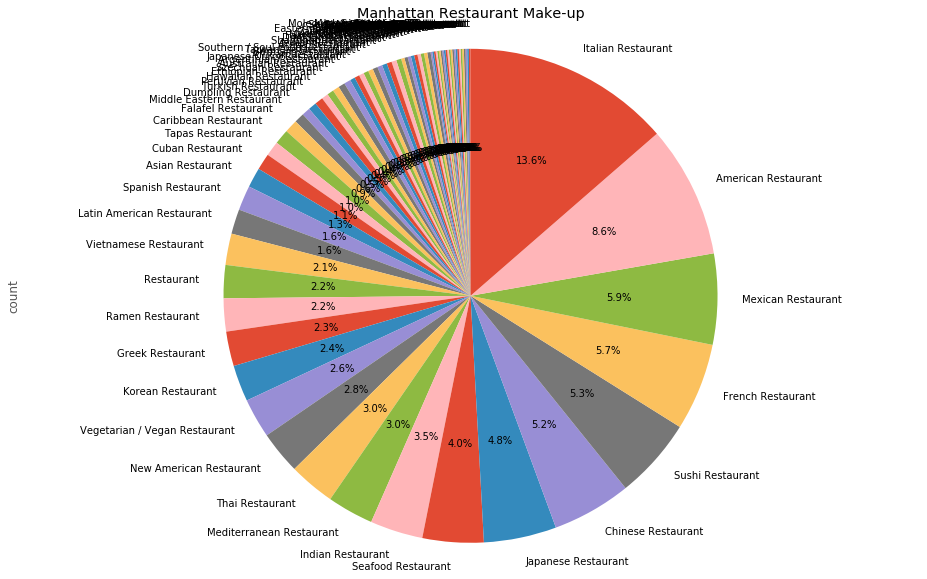

In [32]:
# autopct create %, start angle represent starting point
man_resta['count'].plot(kind='pie',
                            figsize=(16, 10),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=False,       # add shadow      
                            )

plt.title('Manhattan Restaurant Make-up')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

**Let's plot the bar chart and see the actual amount of each restaurant**

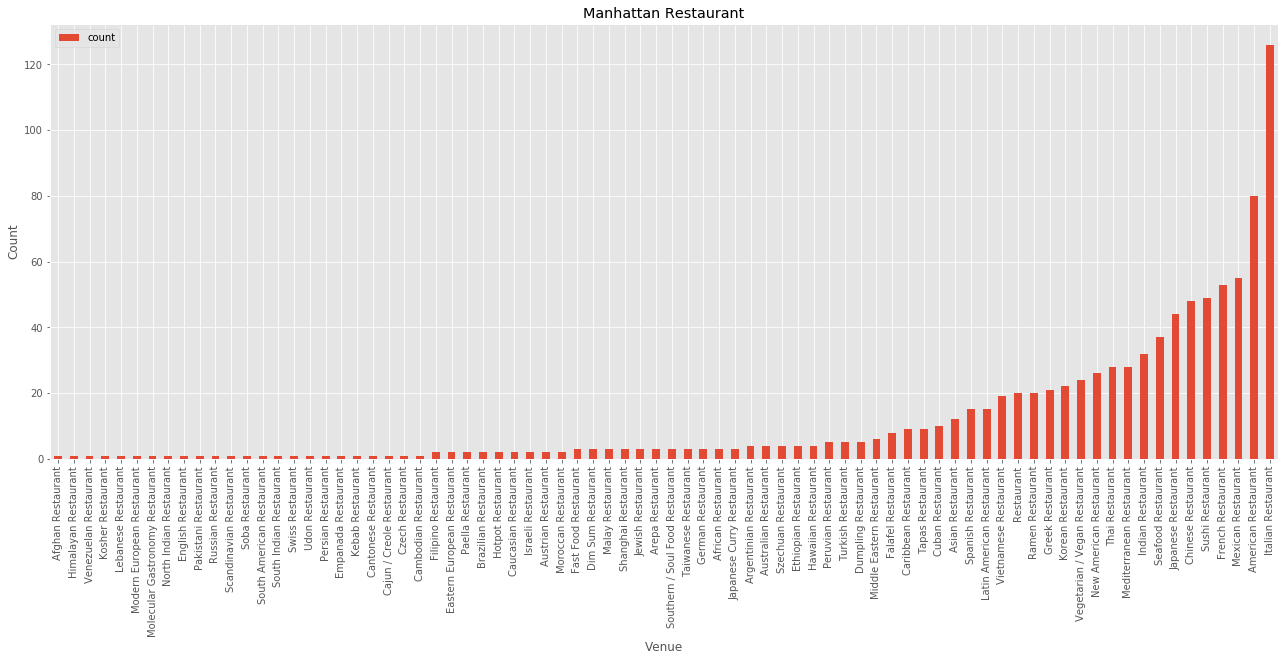

In [33]:
# plot data
man_resta.plot(kind='bar', figsize=(22, 8))

plt.xlabel('Venue') # add to x-label to the plot
plt.ylabel('Count') # add y-label to the plot
plt.title('Manhattan Restaurant') # add title to the plot

plt.show()

**Let's do the same thing for Toronto**

#### Toronto

In [34]:
tor_resta.sort_values(by='count', ascending=True, inplace=True)

print(tor_resta.count())
tor_resta.tail()

count    53
dtype: int64


,count
venues,
American Restaurant,30.0
Japanese Restaurant,39.0
Fast Food Restaurant,41.0
Italian Restaurant,53.0
Restaurant,61.0


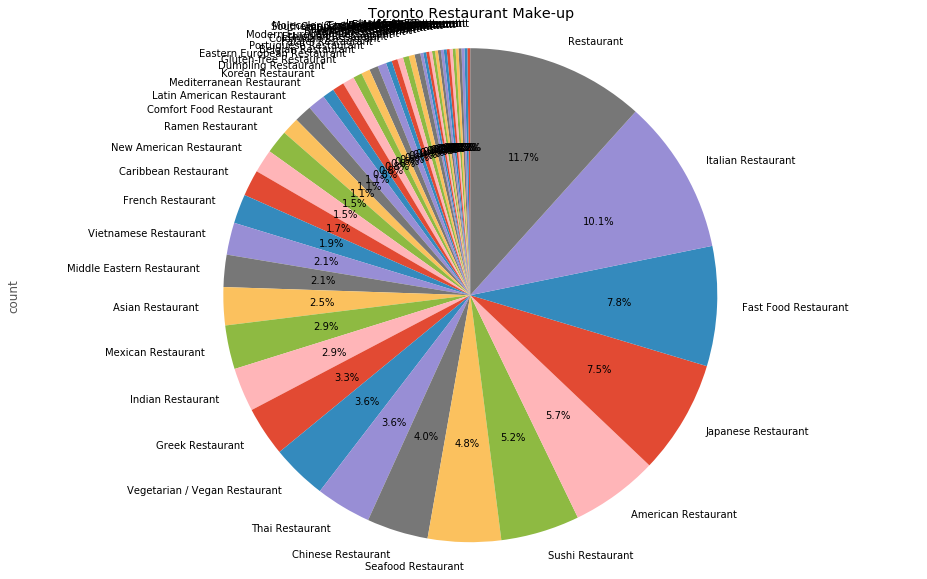

In [35]:
# autopct create %, start angle represent starting point
tor_resta['count'].plot(kind='pie',
                            figsize=(16, 10),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=False,       # add shadow      
                            )

plt.title('Toronto Restaurant Make-up')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

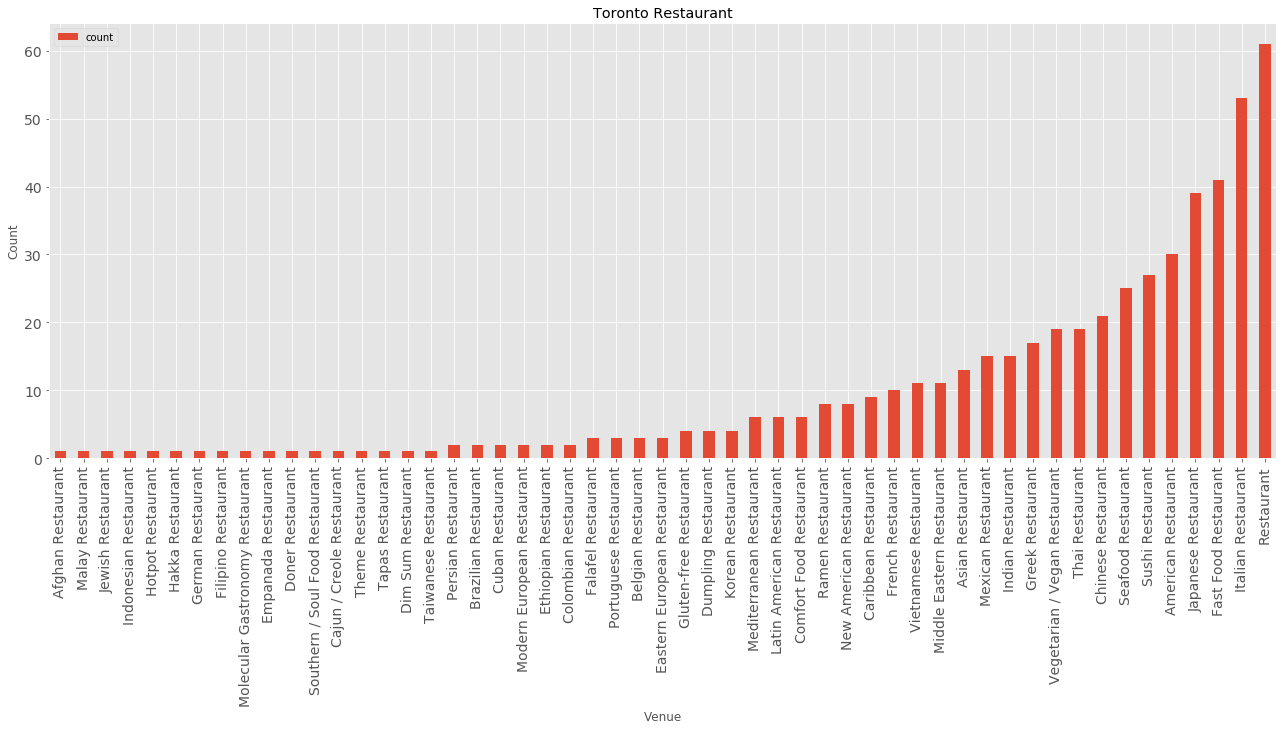

In [36]:
# plot data
tor_resta.plot(kind='bar', figsize=(22, 8), fontsize='14')

plt.xlabel('Venue') # add to x-label to the plot
plt.ylabel('Count') # add y-label to the plot
plt.title('Toronto Restaurant') # add title to the plot

plt.show()

### Italian Restaurant Explore 

Let's dig futher, and only foucs on the Italian restaurant since it's the most common one for both cities. We will filter it from the dataframe we get from foursquare API, and we will label all the Italian restaurants in the map to oberserve their distributions.

**Manhattan**

In [37]:
df_manit = manhattan_venues.loc[manhattan_venues['Venue Category'] == 'Italian Restaurant']
df_manit.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
65,Chinatown,40.715618,-73.994279,Bacaro,40.714468,-73.991589,Italian Restaurant
128,Washington Heights,40.851903,-73.936900,Saggio Restaurant,40.851423,-73.939761,Italian Restaurant
273,Hamilton Heights,40.823604,-73.949688,Fumo,40.821412,-73.950499,Italian Restaurant
336,Manhattanville,40.816934,-73.957385,Pisticci Ristorante,40.814015,-73.960266,Italian Restaurant
342,Manhattanville,40.816934,-73.957385,Bettolona,40.814084,-73.959574,Italian Restaurant


In [38]:
map_manit = folium.Map(location=[latitude2, longitude2], zoom_start=11)

# add markers to map

for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manit)  

for lat, lng, label in zip(df_manit['Neighborhood Latitude'], df_manit['Neighborhood Longitude'], df_manit['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manit)  
    
map_manit

Red markers stand for the neighbourhood that contains the Italian restaurants. As we can see, they are almost everywhere in Manhattan

Let's do the same thing to Toronto

**Toronto**

In [39]:
df_torit = Tor_venues.loc[Tor_venues['Venue Category'] == 'Italian Restaurant']
df_torit=df_torit[df_torit.Neighborhood !='Not assigned']
df_torit.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
67,"Clarks Corners, Sullivan, Tam O'Shanter",43.781638,-79.304302,Remezzo Italian Bistro,43.778649,-79.308264,Italian Restaurant
220,"Flemingdon Park, Don Mills South",43.725900,-79.340923,Sorento Restaurant,43.726575,-79.341989,Italian Restaurant
367,"The Danforth West, Riverdale",43.679557,-79.352188,Cafe Fiorentina,43.677743,-79.350115,Italian Restaurant
374,"The Danforth West, Riverdale",43.679557,-79.352188,7 Numbers,43.677062,-79.353934,Italian Restaurant
402,"The Danforth West, Riverdale",43.679557,-79.352188,Il Fornello,43.678604,-79.346904,Italian Restaurant


In [40]:
# create map of Toronto using latitude and longitude values
map_torit = folium.Map(location=[latitude3, longitude3], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df3['Latitude'], df3['Longitude'], df3['Borough'], df3['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_torit)  

for lat, lng, label in zip(df_torit['Neighborhood Latitude'], df_torit['Neighborhood Longitude'], df_torit['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_torit)    
    
map_torit

Obviously, different from Manhattan, the Italian Restaurants in Tornto are more gathered in downtown area. 

## Results and Discussion <a name="results"></a>

Manhattan, as the center of New York City, does share some similarities with Toronto. Italian restaurant is the most common restaurant in both cities. And venues like Coffee Shop and Japanese restaurants are both make up a big portion among all the venue categories.

The two cities do have a lot of differences in some detail. For example, Toronto has more Coffee Shop and Manhattan has more bars. Toronto has more “Fast Food Restaurant” while Manhattan more focus more on “American Restaurants”. For Italian restaurant, Manhattan almost has it everywhere. But in Toronto they are gathered in the city center or downtown.
It might not be enough to say if Toronto is a more relaxing place with more Coffee Shop than restaurant comparing to Manhattan, since Manhattan contains more venues that make it to be more diverse. But it’s always a good reference to look at these results to explore what we are interested about the city life.
